In [170]:
import numpy as np
from matplotlib import pyplot as plt

In [171]:

class particle():
    def __init__(self, mass, x0, v0):
        self.mass = mass
        self.x0 = x0
        self.v0 = v0

        self.x = x0
        self.v = v0

    def energy(self, v):
        return 0.5 * self.mass * np.linalg.norm(v) ** 2

    def momentum(self):
        return self.mass * self.velocity

class spring():
    def __init__(self, k, x0, v0):
        self.k = k
        self.x0 = x0
        self.v0 = v0

    def energy(self, x):
        return 0.5 * self.k * np.linalg.norm(x - self.x0) ** 2


In [172]:

def euler_integration(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []

    for t in t_array:
        particle.x = particle.x + particle.v * dt
        particle.v = particle.v + force(particle) / particle.mass * dt

        pos.append(particle.x)
        vel.append(particle.v)
        
    return np.array(pos), np.array(vel)

In [173]:
def verlet_integrate(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for i in range(len(t_array)):

        pos.append(particle.x)
        vel.append(particle.v)

        if i == 0:
            x_prev = - (particle.v * dt - particle.x) # this is awful
        else:
            x_prev = pos[i-1]

        a = force(particle) / particle.mass
        x_current = particle.x
        particle.x = 2 * particle.x - x_prev + dt * dt * a
        particle.v = (particle.x - x_current) / dt

    return np.array(pos), np.array(vel)


In [174]:
def actual_verlet_integrate(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for t in t_array:
        pos.append(particle.x)
        vel.append(particle.v)
        particle.x = particle.x + particle.v * dt + 0.5 * force(particle) / particle.mass * dt ** 2
        particle.v = particle.v + force(particle) / particle.mass * dt
    return np.array(pos), np.array(vel)

In [175]:
def runge_kutta(particle, force, t_max, dt = 0.00001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for t in t_array:
        a = force(particle) / particle.mass
        k1 = particle.v
        l1 = a
        k2 = particle.v + l1 * dt / 2
        l2 = a
        k3 = particle.v + l2 * dt / 2
        l3 = a
        k4 = particle.v + l3 * dt
        l4 = a
        particle.x = particle.x + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6
        particle.v = particle.v + (l1 + 2 * l2 + 2 * l3 + l4) * dt / 6
        
        pos.append(particle.x)
        vel.append(particle.v)
    
    return np.array(pos), np.array(vel)

In [180]:
# spring case

class spring_mass_system():
    def __init__(self, mass, k, x_m = np.zeros(3, dtype = float), v0 = np.zeros(3, dtype = float), x_s = np.zeros(3, dtype = float)):
        self.k = k
        self.mass = mass

        self.spring = spring(k, x_s, v0)
        self.particle = particle(mass, x_m, v0)

    def energy(self):
        return self.spring.energy(self.particle.x) + self.particle.energy(self.particle.v)
    
    def force(self, particle):
        #return np.gradient(self.energy(particle.x), particle.x)
        return - self.k * (particle.x - self.spring.x0)
    
    def solve(self, method, t_max, dt = 0.001):
        pos,vel = method(self.particle, self.force, t_max, dt)
        return pos, vel
    
    def solution(self, t):
        x0 = self.particle.x0[0]
        v0 = self.particle.v0[0]
        w = np.sqrt(self.k / self.mass)
        A = x0
        B = v0 / w
        return A * np.cos(w * t) + B * np.sin(w * t)


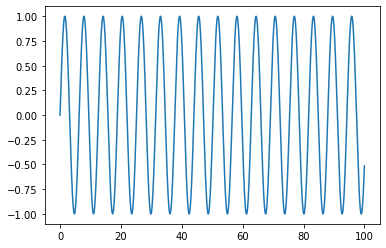

In [177]:
mass_position = np.array([0, 0, 0], dtype = float)
velocity = np.array([1, 0, 0], dtype = float)
system = spring_mass_system(1, 1, mass_position, velocity)

T = 100
dt = 0.01

pos,vel = system.solve(verlet_integrate, T, dt)
t_array = np.arange(0, T, dt)
plt.plot(t_array, pos[:, 0])
#plt.plot(t_array, system.solution(t_array))

final rms error for verlet_integrate is 0.021737093476654562
final rms error for euler_integration is 0.04485855398714776
final rms error for actual_verlet_integrate is 0.4710996863762726
final rms error for runge_kutta is 1.2015049978296484


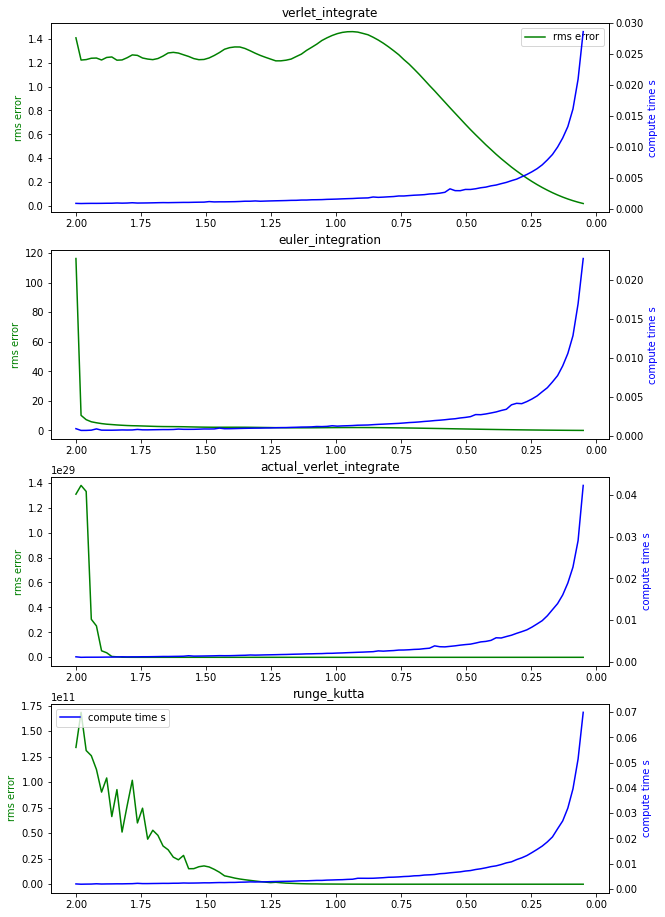

In [178]:
errors = []
solve_times = []

def test_iteration(method, dt):
  
  T = 100
  mass_position = np.array([1, 0, 0], dtype = float)
  velocity = np.array([1, 0, 0], dtype = float)
  system = spring_mass_system(1, 1, mass_position, velocity)

  pos, vel = system.solve(method, T, dt)
  t_array = np.arange(0, T, dt)
  rms_error = np.sqrt(np.mean((pos[:, 0] - system.solution(t_array)) ** 2, axis = 0))
  errors.append( rms_error )


def test_method(plot_axis, method):
  solve_times = []
  errors = []
  time_steps = np.linspace(2,0.05,100)
  for dt in time_steps:
    t = %timeit -q -n1 -r1 -o test_iteration(method,dt)
    solve_times.append(t.best)

  plot_axis.plot(time_steps, errors, 'g', label = 'rms error')
  plot_axis.set_ylabel('rms error', color='g')
  time_axis = plot_axis.twinx()
  time_axis.plot(time_steps, solve_times, 'b', label='compute time s')
  time_axis.set_ylabel('compute time s', color='b')
  plot_axis.set_title(method.__name__)
  plot_axis.set_xlim(plot_axis.get_xlim()[::-1])

  print(f"final rms error for {method.__name__} is {errors[-1]}")


methods = [verlet_integrate, euler_integration, actual_verlet_integrate, runge_kutta]
fig, axs = plt.subplots(len(methods), 1, figsize = (10, 4*len(methods)))

for m in methods:
  test_method(axs[methods.index(m)], m)

axs[0].legend()

plt.legend()
plt.show()

runge kutta method may seem worse, however its second, third and fourth derivatives are far more accurate than any of the other methods

Dont know what the definiton of unstable is but is around when dt = 1.95 to 2.0

energy change is 10.017934930404644 at dt = 1.9597989949748744
energy change is 13.484662468634673 at dt = 1.9698492462311559
energy change is 22.280475231096425 at dt = 1.979899497487437
energy change is 25.920287087939887 at dt = 1.9899497487437188
energy change is 65.8144015835039 at dt = 1.9949748743718594
energy change is 5000.0 at dt = 2.0
energy change is 5000.0


Text(0, 0.5, 'energy error')

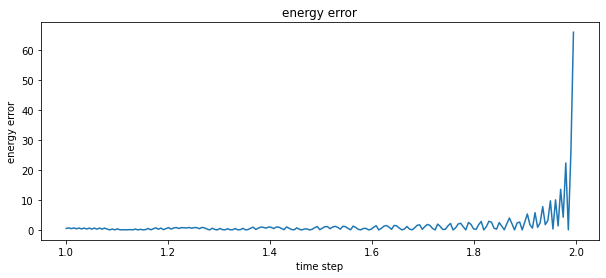

In [195]:


T = 100
time_steps = np.linspace(1,2,200)

energy_errors = []

for dt in time_steps:
    mass_position = np.array([0, 0, 0], dtype = float)
    velocity = np.array([1, 0, 0], dtype = float)
    system = spring_mass_system(1, 1, mass_position, velocity)
    initial_energy = system.energy()
    pos,vel = system.solve(verlet_integrate, T, dt)
    final_energy = system.energy()
    energy_change = np.abs(final_energy - initial_energy)
    if energy_change > 10:
        print(f"energy change is {energy_change} at dt = {dt}")
        if energy_change > 100:
            break
        
    energy_errors.append(energy_change)

print(f"energy change is {final_energy - initial_energy}")

fig, ax = plt.subplots(1, 1, figsize = (10, 4))

ax.plot(time_steps[:len(energy_errors)], energy_errors)
ax.set_title('energy error')
ax.set_xlabel('time step')
ax.set_ylabel('energy error')
#plt.plot(t_array, system.solution(t_array))

In [196]:
G = 6.67408e-11

class orbital_system():
    def __init__(self, M, m, planet_pos, planet_vel): # relative to sun
        self.M = M
        self.m = m

        self.sun = particle(M, np.zeros(3), np.zeros(3)) # coordinate system based on star
        self.planet = particle(m, planet_pos, planet_vel)
    
    def force(self, particle): # force on planet
        return -G * self.M * self.m * particle.x / np.linalg.norm(particle.x) ** 3

    def solve(self, method, t_max, dt = 0.001):
        pos,vel = method(self.planet, self.force, t_max, dt)
        return pos, vel


Scenario 1

Text(0, 0.5, 'altitude (m)')

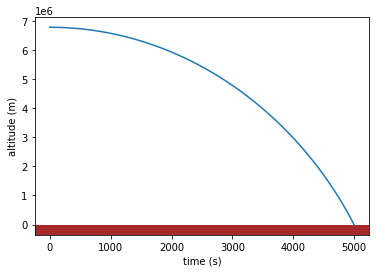

In [197]:
from matplotlib.patches import Rectangle

mars_mass = 6.42e23
mars_radius = 3.3895e6
meteor_mass = 1e3

initial_altitude = 3 * mars_radius

meteor_position = np.array([initial_altitude, 0, 0], dtype = float)
meteor_velocity = np.array([0, 0, 0], dtype = float)

meteor_planet_collision = orbital_system(mars_mass, meteor_mass, meteor_position, meteor_velocity)

T = 5000
dt = 0.01
t_array = np.arange(0, T, dt)
pos, vel = meteor_planet_collision.solve(verlet_integrate, T, dt)

altidudes = np.linalg.norm(pos, axis = 1) - mars_radius

ax = plt.gca()
ax.plot(t_array, altidudes)
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.add_patch(Rectangle((x0 - .5, y0 - .5), x1 - x0, - y0, facecolor="brown"))
plt.xlabel('time (s)')
plt.ylabel('altitude (m)')

Scenario 2

Phobos orbiting mars in a circular orbit. Phobos is actually in an orbit of eccentricity 0.0151 which still looks like a circle

(-10315800.315990195,
 10315800.01915619,
 -10315907.03773478,
 10315693.297616169)

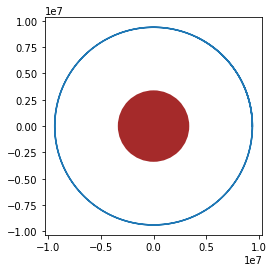

In [ ]:
from matplotlib.patches import Circle

mars_mass = 6.42e23
mars_radius = 3.3895e6
phobos_mass = 1.0659e16
phobos_orbit_radius = 9.378e6

def velocity_for_circular_orbit(m1, m2, r):
    return np.sqrt(G * (m1 + m2) / r)

phobos_position = np.array([phobos_orbit_radius, 0, 0], dtype = float)
phobos_velocity = np.array([0, velocity_for_circular_orbit(mars_mass, phobos_mass, phobos_orbit_radius), 0])
mars_moons_orbit = orbital_system(mars_mass, phobos_mass, phobos_position, phobos_velocity)

pos,vel = mars_moons_orbit.solve(verlet_integrate, 60000, 0.1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), mars_radius, facecolor="brown"))
ax.axis('scaled')

Scenario 3

Elliptic orbit of Bennu, an asteroid thats also a potentially hazardous object which has a high chance of impacting earth between the years 2178 - 2290.
Bennu has an orbit of eccentricity of 0.20375
The sun is also scaled up by 100x to be seen clearly

(-1163936035443.9985,
 195987716216.89737,
 -423096352174.9031,
 422902890022.3245)

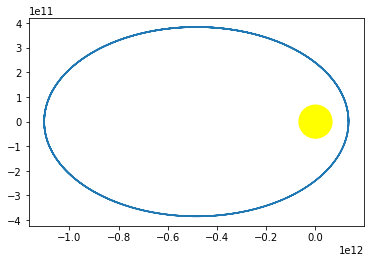

In [ ]:
sun_mass = 1.989e30
sun_radius = 6.957e8
bennu_mass = 7.329e10

bennu_position = np.array([134.173e9, 0, 0])
bennu_velocity = np.array([0, 1.5*28e3, 0])

mars_moons_orbit = orbital_system(sun_mass, bennu_mass, bennu_position, bennu_velocity)

pos,vel = mars_moons_orbit.solve(verlet_integrate, 1000000000, 1000)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), sun_radius * 10 ** 2, facecolor="yellow"))
ax.axis('scaled')

Scenario 4 Voyager 1 jupyter gravity jump

(-1123410616.8779309,
 521432955.4507398,
 -492239057.15371114,
 1108768200.6336105)

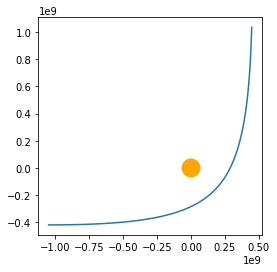

In [ ]:

jupyter_mass = 1.898e27
jupyter_radius = 6.9911e7
voyager1_mass = 825.5
voyager1_position = np.array([- 15 * jupyter_radius, - 6 * jupyter_radius, 0])
voyager1_velocity = np.array([2e4, 0, 0])

voyager1_gravity_jump = orbital_system(jupyter_mass, voyager1_mass, voyager1_position, voyager1_velocity)

pos,vel = voyager1_gravity_jump.solve(verlet_integrate, 100000, 1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), jupyter_radius, facecolor="orange"))
ax.axis('scaled')

Scenario 4 part 2 hyperbolic escape from planet surface
Future Clipper spacecraft taking off from Jupyters moon Europa

(-2200974.220367052,
 11900458.627708094,
 -1908231.957275461,
 2071936.2238784838)

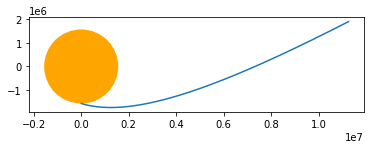

In [ ]:

europa_mass = 4.799e22
europa_radius = 1.56e6
clipper_mass = 400
clipper_position = np.array([0, - europa_radius, 0])
clipper_velocity = np.array([2e3, -6e2, 0])

clipper_hyperbolic_escape = orbital_system(europa_mass, clipper_mass, clipper_position, clipper_velocity)

pos,vel = clipper_hyperbolic_escape.solve(verlet_integrate, 10000, 1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), europa_radius, facecolor="orange"))
ax.axis('scaled')